In [1]:
import networkx as nx
import numpy as np
import random
from collections import deque
from multiprocessing import Pool
import matplotlib.pyplot as plt

import spectral_embedding as spe
from data import test_data
import preprocessing as pre
import cluster_refinement as refinement
import deformations as deform
import visual_aids as visual

Graph alb2000.hcp.gz: 2000 nodes, 3996 edges
Graph alb4000.hcp.gz: 4000 nodes, 7997 edges
Graph alb3000b.hcp.gz: 3000 nodes, 5997 edges
Graph alb3000d.hcp.gz: 3000 nodes, 5993 edges
Graph alb5000.hcp.gz: 5000 nodes, 9999 edges
Graph alb3000a.hcp.gz: 3000 nodes, 5999 edges
Graph alb3000c.hcp.gz: 3000 nodes, 5996 edges
Graph alb1000.hcp.gz: 1000 nodes, 1998 edges
Graph alb3000e.hcp.gz: 3000 nodes, 5996 edges


In [2]:
H = random.choice(list(test_data.values()))

In [3]:
data = spe.fast_eigen_decomp(H, 4000)
labels = spe.get_partitions(data)

graph size 3000 <= 4000: using full dense eigen-decomposition with k = 20
calculating gaps between normalized laplacian eigenvalues
std gaps 0.0003184265661629162
max gap 0.0035452570125691363
number of similar gaps, including largest 1
calculating gaps between normalized signless laplacian eigenvalues
std gaps 0.0025058293212230054
max gap -6.62263424666687e-06
number of similar gaps, including largest 2998


TypeError: 'NoneType' object is not subscriptable

In [ ]:
def in_clusters(G, labels):
    clusters = {}
    for i, node in enumerate(G.nodes()):
        clusters.setdefault(labels[i], []).append(node)
    subgraphs = {label:G.subgraph(nodes).copy() for label, nodes in clusters.items()}
    return clusters, subgraphs

In [ ]:
clusters, subgraphs = in_clusters(H, labels)
print(clusters)
print(subgraphs)
print([s.number_of_nodes() for s in subgraphs.values()])

{np.int32(1): [3000, 1768, 2999, 1776, 773, 14, 2998, 2997, 1634, 595, 153, 2996, 1793, 1726, 1449, 2995, 1772, 1496, 786, 2994, 2993, 1197, 1809, 1721, 2992, 149, 2989, 2988, 1279, 722, 2987, 2986, 1417, 761, 2985, 711, 785, 666, 2984, 179, 651, 2980, 2979, 1298, 662, 2968, 1805, 261, 50, 2967, 1215, 2966, 1804, 768, 178, 2965, 269, 145, 2964, 1546, 782, 185, 2963, 65, 2960, 1803, 1570, 2959, 780, 200, 2958, 2957, 701, 272, 1802, 2947, 1801, 1551, 2946, 2945, 1795, 2944, 1389, 2943, 1475, 672, 48, 2942, 2941, 1658, 2940, 1401, 2939, 2938, 230, 1800, 273, 2937, 2936, 1212, 525, 2935, 2934, 608, 75, 2933, 742, 268, 2931, 2930, 1711, 1384, 655, 2929, 1400, 1252, 1203, 2928, 1798, 1631, 186, 2927, 2926, 1202, 196, 1283, 2924, 1724, 1195, 262, 2923, 2922, 1725, 1191, 1796, 202, 2921, 2920, 415, 1457, 259, 2919, 2918, 1605, 1794, 734, 2917, 2916, 763, 2915, 2914, 1418, 2913, 607, 1792, 2912, 2911, 689, 2910, 157, 720, 536, 2905, 2904, 678, 969, 1679, 2900, 1642, 2899, 1404, 1254, 2884, 1785

In [20]:
def build_cluster_graph(G, clusters):
    meta = nx.Graph()
    for label, nodes in clusters.items():
        meta.add_node(label, size=len(nodes))
    for label1, nodes1 in clusters.items():
        for label2, nodes2 in clusters.items():
            if label1 < label2:
                weight = 0
                for u in nodes1:
                    for v in nodes2:
                        if G.has_edge(u, v):
                            weight += 1
                if weight > 0:
                    meta.add_edge(label1, label2, weight=weight)
    return meta

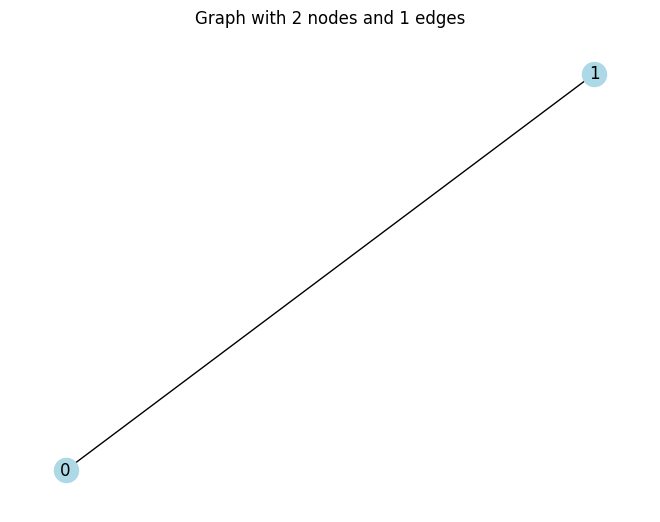

In [21]:
qgraph = build_cluster_graph(H, clusters)
visual.draw(qgraph)

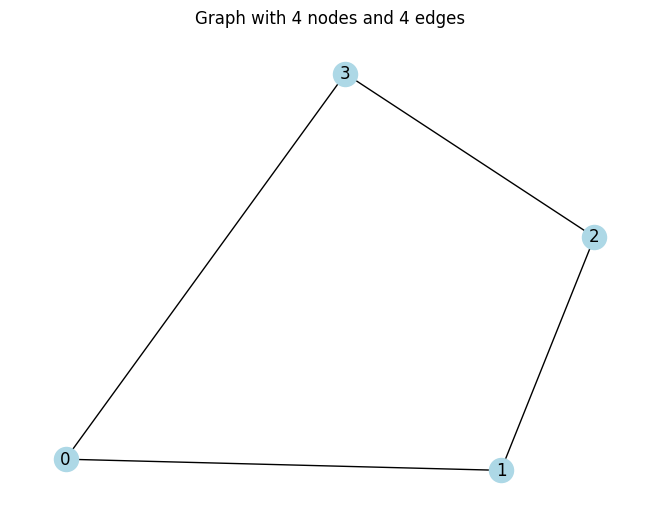

In [56]:
pruned = deform.aggressive_pruning(qgraph)
visual.draw(pruned)

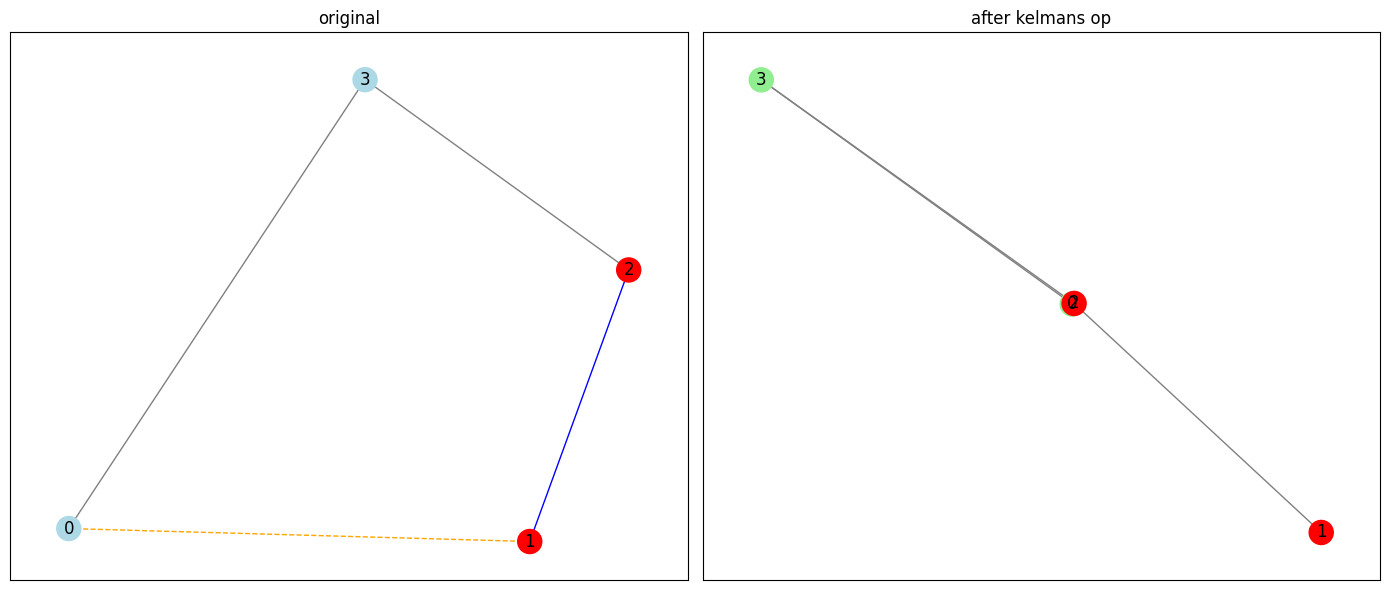

In [57]:
u,v = refinement.select_kelmans_candidate(pruned)
visual.visualize_kelmans_operation(pruned, u,v)

In [24]:
def draw_large_graph(G, with_labels=False):
    n = G.number_of_nodes()
    node_size = max(5, int(2000/ n))
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='blue', alpha=0.7)
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)
    if with_labels:
        nx.draw_networkx_labels(G, pos, font_size=8)
    plt.axis('off')
    plt.show()

Graph with 1991 nodes and 3265 edges


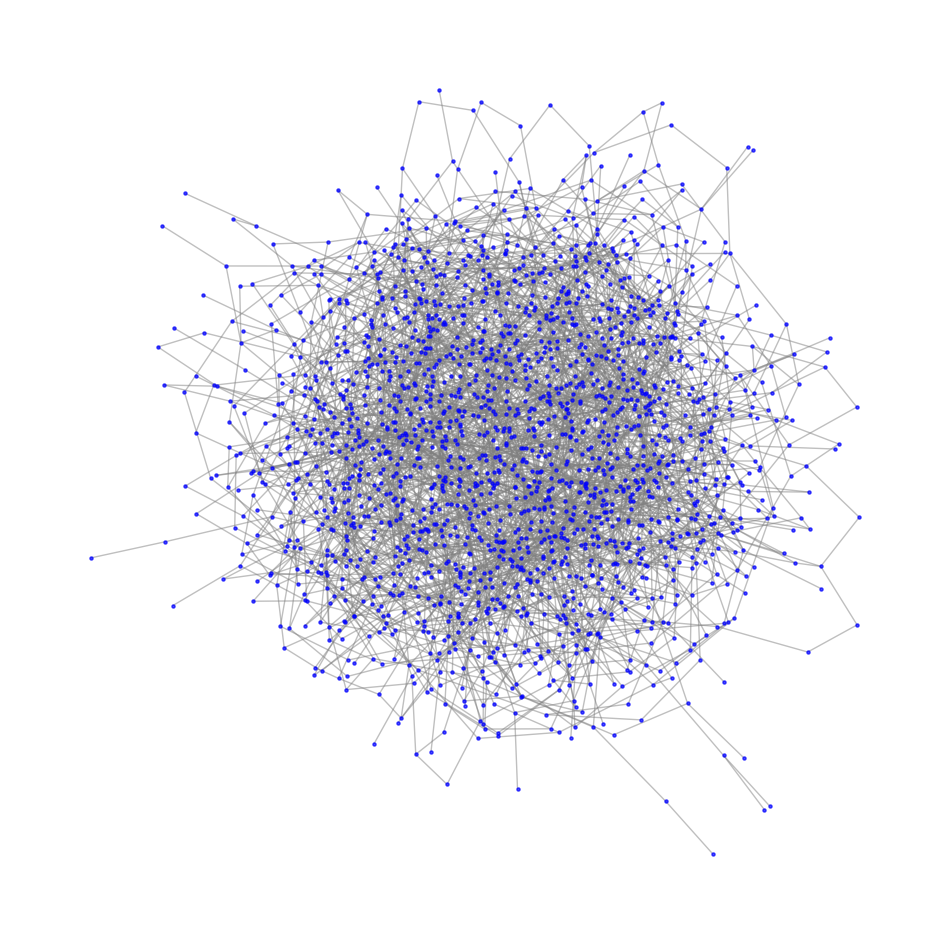

Graph with 2009 nodes and 3332 edges


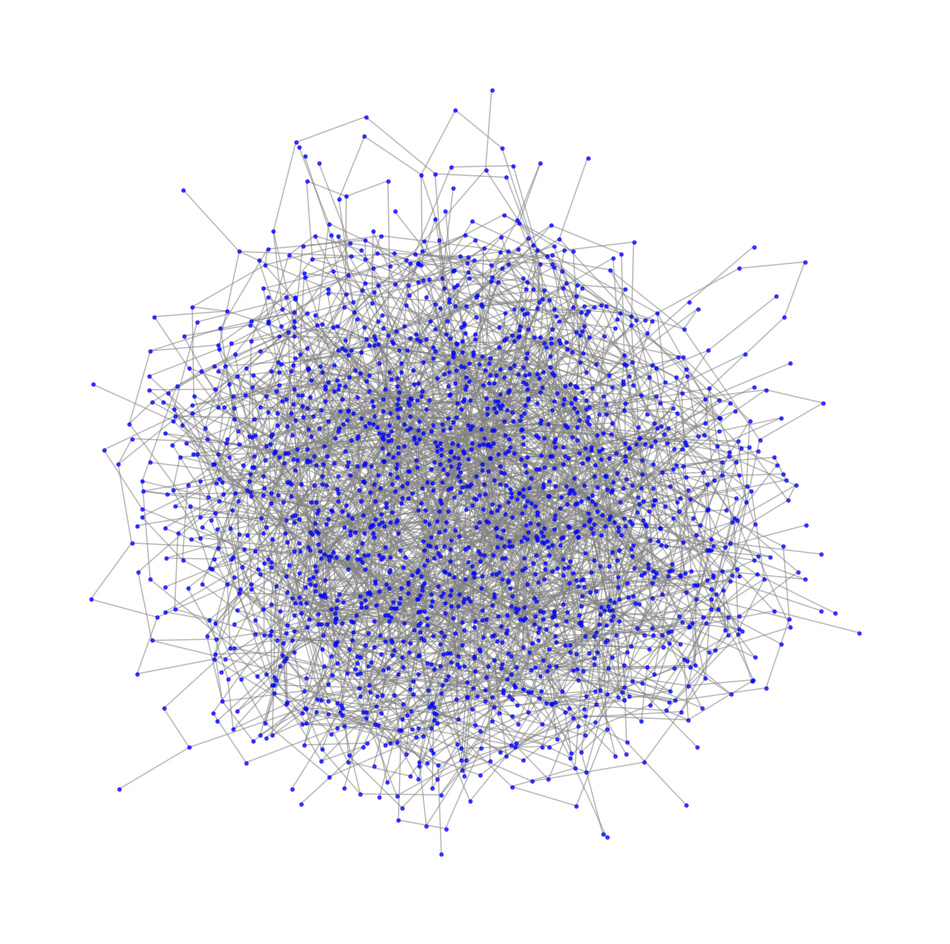

In [25]:
for i in subgraphs:
    s = subgraphs[i]
    print(f"{s}")
    draw_large_graph(s)

In [26]:
contracted_subs = []

for i in subgraphs.keys():
    s = subgraphs[i]
    contract2_s = pre.contract_deg2(s)
    contracted_subs.append(contract2_s)

Graph with 1612 nodes and 2886 edges


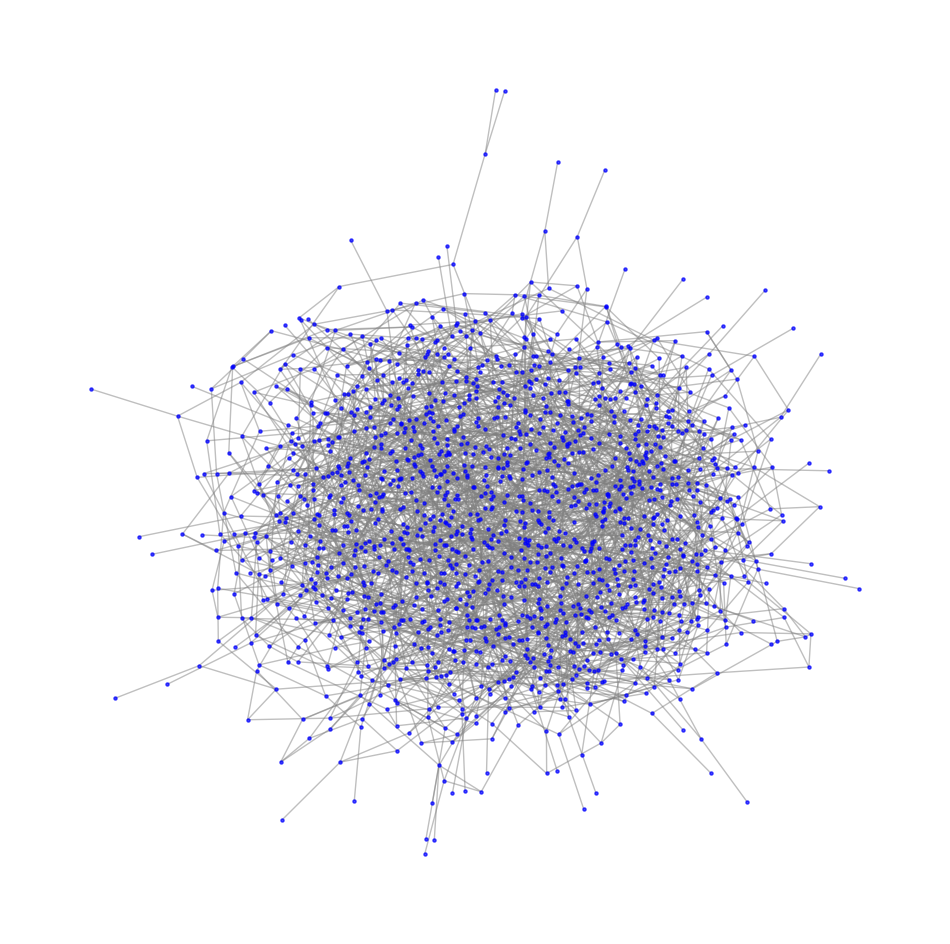

Graph with 1647 nodes and 2969 edges


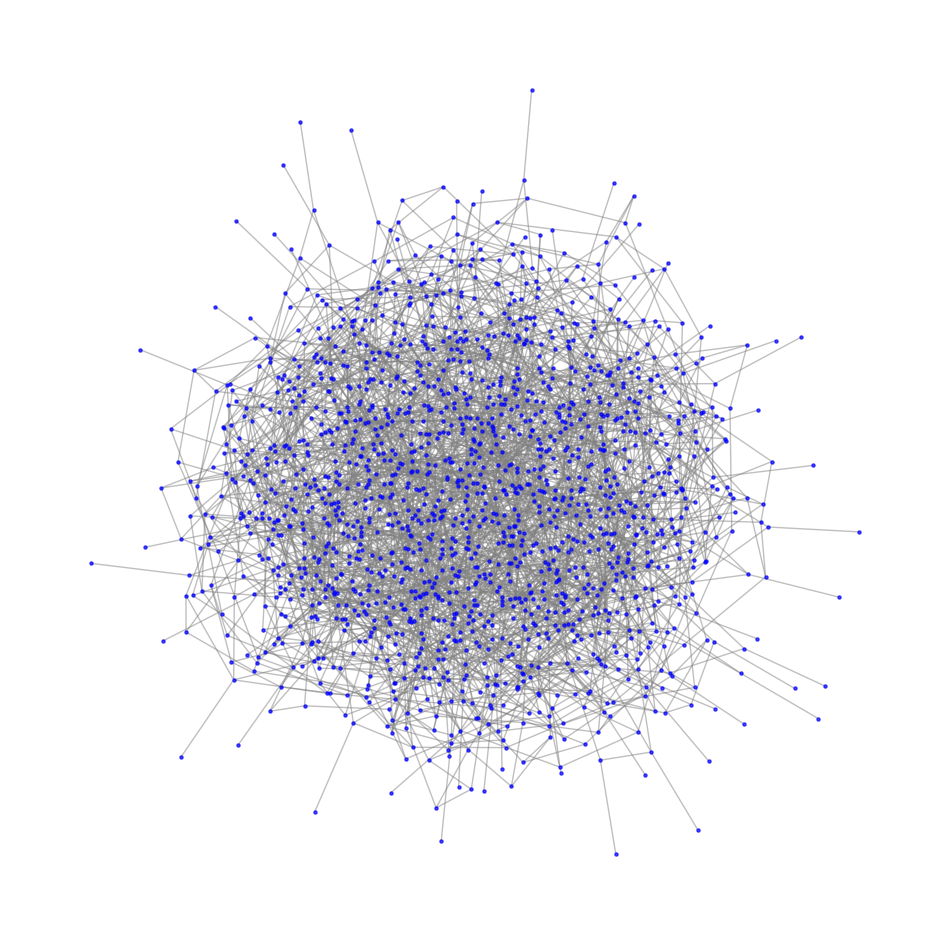

In [27]:
for s in contracted_subs:
    print(f"{s}")
    draw_large_graph(s)